# Evaluate TrivialAugment-style Augmentation Strategy on BUSI

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.multitest import multipletests
from tbparse import SummaryReader

INDIVIDUAL_LOG_DIR = "../tensorboard_logs/individual_effects/busi"
TRIVIAL_AUG_LOG_DIR = "../tensorboard_logs/trivial_augment/busi"

## Load Tensorboard Logs

In [2]:
reader = SummaryReader(TRIVIAL_AUG_LOG_DIR, extra_columns={"wall_time", "dir_name"})

trivial_df = reader.scalars
trivial_df["wall_time"] = pd.to_datetime(trivial_df["wall_time"], unit="s")
trivial_df[["augmentations", "ops", "split", "train_fold", "log_dir", "run"]] = (
    trivial_df["dir_name"].str.split(pat="/", n=5, expand=True)
)
trivial_df["ops"] = trivial_df["ops"].str.replace("ops_", "").astype(int)
trivial_df["split"] = trivial_df["split"].str.replace("split_", "").astype(int)
trivial_df["train_fold"] = (
    trivial_df["train_fold"].str.replace("trainfold_", "").astype(int)
)
trivial_df["run"] = trivial_df["run"].str.replace("version_", "").astype(int)
trivial_df = trivial_df.drop(columns=["log_dir"])
trivial_df.head()

,step,tag,value,wall_time,dir_name,augmentations,ops,split,train_fold,run
0,4,epoch,0.0,2024-03-05 20:47:11.556095839,all/ops_1/split_0/trainfold_0/lightning_logs/v...,all,1,0,0,45337074
1,5,epoch,0.0,2024-03-05 20:47:13.341581345,all/ops_1/split_0/trainfold_0/lightning_logs/v...,all,1,0,0,45337074
2,5,epoch,0.0,2024-03-05 20:47:13.765635252,all/ops_1/split_0/trainfold_0/lightning_logs/v...,all,1,0,0,45337074
3,9,epoch,1.0,2024-03-05 20:47:17.529276133,all/ops_1/split_0/trainfold_0/lightning_logs/v...,all,1,0,0,45337074
4,11,epoch,1.0,2024-03-05 20:47:20.054951429,all/ops_1/split_0/trainfold_0/lightning_logs/v...,all,1,0,0,45337074


In [3]:
reader = SummaryReader(INDIVIDUAL_LOG_DIR, extra_columns={"wall_time", "dir_name"})

individual_df = reader.scalars
individual_df["wall_time"] = pd.to_datetime(individual_df["wall_time"], unit="s")
individual_df[["transform", "split", "train_fold", "log_dir", "run"]] = individual_df[
    "dir_name"
].str.split(pat="/", n=4, expand=True)
individual_df["train_fold"] = (
    individual_df["train_fold"].str.replace("trainfold_", "").astype(int)
)
individual_df["split"] = individual_df["split"].str.replace("split_", "").astype(int)
individual_df["run"] = individual_df["run"].str.replace("version_", "").astype(int)
individual_df = individual_df.drop(columns=["log_dir"])
individual_df.head()

,step,tag,value,wall_time,dir_name,transform,split,train_fold,run
0,4,epoch,0.0,2024-03-04 23:56:46.265971422,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134
1,5,epoch,0.0,2024-03-04 23:56:48.010061502,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134
2,5,epoch,0.0,2024-03-04 23:56:48.520948887,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134
3,9,epoch,1.0,2024-03-04 23:56:50.283200264,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134
4,11,epoch,1.0,2024-03-04 23:56:52.042407990,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134


## Merge Results

Add the baseline (no augmentation) performance for each (fold, seed) pair to the results.

In [5]:
baseline_df = (
    individual_df[individual_df["tag"] == "val/bacc_epoch"][
        ["transform", "split", "train_fold", "run", "value"]
    ]
    .groupby(["transform", "split", "train_fold", "run"])
    .max("value")
    .reset_index()
)
baseline_df = baseline_df[baseline_df["transform"] == "center_crop"]

summary_df = (
    trivial_df[trivial_df["tag"] == "val/bacc_epoch"][
        ["augmentations", "ops", "split", "train_fold", "run", "value"]
    ]
    .groupby(["augmentations", "ops", "split", "train_fold", "run"])
    .max("value")
    .reset_index()
)
summary_df = pd.merge(summary_df, baseline_df, on=["split", "train_fold"])
summary_df = summary_df.rename(columns={"value_x": "bacc", "value_y": "baseline_bacc"})
summary_df["diff"] = summary_df["bacc"] - summary_df["baseline_bacc"]
summary_df.head()
summary_df = summary_df.drop(columns=["run_x", "run_y", "transform"])
summary_df.to_csv("../results/busi_trivial_augment_runs.csv", index=False)
summary_df.head()

,augmentations,ops,split,train_fold,bacc,baseline_bacc,diff
0,all,1,0,0,0.846360,0.771873,0.074487
1,all,1,0,1,0.833722,0.788292,0.045429
2,all,1,1,0,0.828095,0.759803,0.068292
3,all,1,1,1,0.855827,0.808978,0.046849
4,all,1,2,0,0.844731,0.777515,0.067216


## Primary Study

In [10]:
primary_df = summary_df[summary_df["augmentations"].isin(["all", "top10", "top5"])]

### Visualize Performance Gains

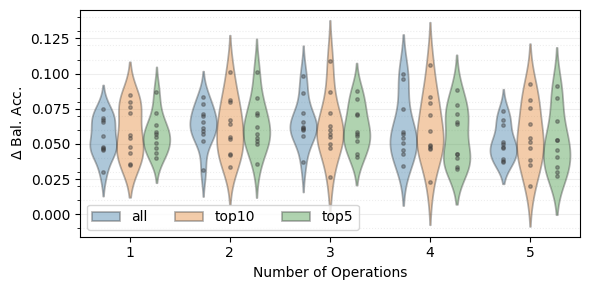

In [11]:
fig = plt.figure(figsize=(6, 3))

C0 = [0.19460784, 0.45343137, 0.63284314, 1.0]
C1 = [0.88186275, 0.50539216, 0.17303922, 1.0]

# Draw violins
ax = sns.violinplot(
    primary_df,
    x="ops",
    y="diff",
    hue="augmentations",
    order=sorted(primary_df["ops"].unique()),
    inner="points",
    density_norm="count",
    cut=2,
)
for violin, alpha in zip(ax.collections, [0.4] * len(ax.collections)):
    violin.set_alpha(alpha)

# Gridlines
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.grid(True, which="major", color="#EEEEEE")
ax.yaxis.grid(True, which="minor", color="#EEEEEE", linestyle=":")
ax.set_axisbelow(True)

# Legend
for x in ax.get_legend_handles_labels()[0]:
    x.set_alpha(0.4)
ax.legend(loc="lower left", ncols=3)

# Axes
plt.xlabel("Number of Operations")
plt.ylabel("$\Delta$ Bal. Acc.")

plt.tight_layout()
plt.savefig("../results/busi_trivial_augment.pdf", bbox_inches="tight")
plt.show()

### Significance Testing

- 5 x 2 cross validation with one-sided $t$ tests with Holm-Bonferroni correction.

In [12]:
def perform_ttest(df):
    """Implements the 5 x 2 CV paired t test proposed by Dieterrich (1998) to compare the
    performance of two learning algorithms.

    Modified from MLxtend: https://github.com/rasbt/mlxtend/blob/b3b81f4dd603e0ad9c8f3133f1b2bf2f5177cc9d/mlxtend/evaluate/ttest.py#L237
    """
    first_diff = None
    variance_sum = 0.0
    for split in range(5):
        diff_fold0 = df[(df["train_fold"] == 0) & (df["split"] == split)]["diff"].iloc[
            0
        ]
        diff_fold1 = df[(df["train_fold"] == 1) & (df["split"] == split)]["diff"].iloc[
            0
        ]

        diff_mean = (diff_fold0 + diff_fold1) / 2.0
        diff_var = (diff_fold0 - diff_mean) ** 2 + (diff_fold1 - diff_mean) ** 2

        variance_sum += diff_var
        if first_diff is None:
            first_diff = diff_fold0

    numerator = first_diff
    denominator = np.sqrt(1 / 5.0 * variance_sum)
    t_stat = numerator / denominator

    p_value = stats.t.sf(t_stat, 5)

    return t_stat, p_value

In [13]:
# Calculate p values
p_values = []
for i in primary_df["augmentations"].unique():
    for j in primary_df["ops"].unique():
        t_stat, p_value = perform_ttest(
            primary_df[(primary_df["augmentations"] == i) & (primary_df["ops"] == j)]
        )
        p_values.append((i, j, t_stat, p_value))
p_values = pd.DataFrame(p_values, columns=["augmentations", "ops", "t_stat", "p_value"])

# Calculate means
results_df = (
    primary_df.groupby(["augmentations", "ops", "split"])
    .mean()
    .reset_index()
    .drop(columns=["train_fold"])
)
results_df = (
    results_df.groupby(["augmentations", "ops"])
    .mean()
    .reset_index()
    .drop(columns=["split"])
)

# Add p values
results_df = pd.merge(
    results_df,
    p_values,
    left_on=["augmentations", "ops"],
    right_on=["augmentations", "ops"],
)

# Perform multiple testing correction
reject, p_values_adj, _, _ = multipletests(results_df["p_value"], method="holm")
results_df["p_value_adj"] = p_values_adj
results_df["reject"] = reject

results_df.to_csv("../results/busi_trivial_augment.csv", index=False)
results_df.head(20)

,augmentations,ops,bacc,baseline_bacc,diff,t_stat,p_value,p_value_adj,reject
0,all,1,0.844557,0.789712,0.054845,4.549984,0.003056,0.019818,True
1,all,2,0.852591,0.789712,0.062880,6.514957,0.000637,0.008913,True
2,all,3,0.855498,0.789712,0.065786,6.418023,0.000681,0.008913,True
3,all,4,0.851034,0.789712,0.061322,3.981851,0.005256,0.019818,True
4,all,5,0.841195,0.789712,0.051484,4.275593,0.003948,0.019818,True
5,top10,1,0.848334,0.789712,0.058623,3.869790,0.005881,0.019818,True
6,top10,2,0.851654,0.789712,0.061942,4.783683,0.002477,0.019818,True
7,top10,3,0.852420,0.789712,0.062708,4.663058,0.002758,0.019818,True
8,top10,4,0.851027,0.789712,0.061316,5.697381,0.001162,0.011622,True
9,top10,5,0.845647,0.789712,0.055935,4.313235,0.003810,0.019818,True


## Follow-Up Ablation Study on Geometric vs. Photometric Transforms

In [14]:
ablation_df = summary_df[summary_df["augmentations"].isin(["photometric", "geometric"])]

### Visualize Performance Gains

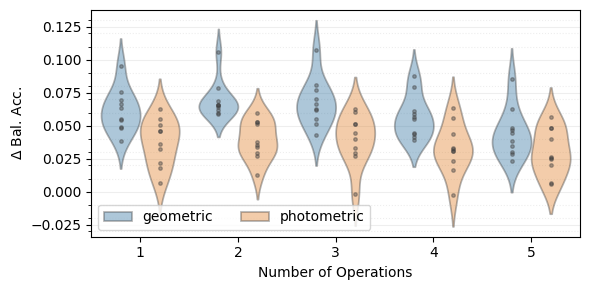

In [15]:
fig = plt.figure(figsize=(6, 3))

C0 = [0.19460784, 0.45343137, 0.63284314, 1.0]
C1 = [0.88186275, 0.50539216, 0.17303922, 1.0]

# Draw violins
ax = sns.violinplot(
    ablation_df,
    x="ops",
    y="diff",
    hue="augmentations",
    order=sorted(ablation_df["ops"].unique()),
    inner="points",
    density_norm="count",
    cut=2,
)
for violin, alpha in zip(ax.collections, [0.4] * len(ax.collections)):
    violin.set_alpha(alpha)

# Gridlines
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.grid(True, which="major", color="#EEEEEE")
ax.yaxis.grid(True, which="minor", color="#EEEEEE", linestyle=":")
ax.set_axisbelow(True)

# Legend
for x in ax.get_legend_handles_labels()[0]:
    x.set_alpha(0.4)
ax.legend(loc="lower left", ncols=3)

# Axes
plt.xlabel("Number of Operations")
plt.ylabel("$\Delta$ Bal. Acc.")

plt.tight_layout()
plt.savefig("../results/busi_trivial_augment_ablation.pdf", bbox_inches="tight")
plt.show()

### Calculate Statistics

In [16]:
# Calculate means
results_df = (
    ablation_df.groupby(["augmentations", "ops", "split"])
    .mean()
    .reset_index()
    .drop(columns=["train_fold"])
)
results_df = (
    results_df.groupby(["augmentations", "ops"])
    .mean()
    .reset_index()
    .drop(columns=["split"])
)

results_df.to_csv("../results/busi_trivial_augment_ablation.csv", index=False)
results_df.head(20)

,augmentations,ops,bacc,baseline_bacc,diff
0,geometric,1,0.851314,0.789712,0.061602
1,geometric,2,0.859367,0.789712,0.069655
2,geometric,3,0.857360,0.789712,0.067648
3,geometric,4,0.846490,0.789712,0.056778
4,geometric,5,0.833930,0.789712,0.044218
5,photometric,1,0.827343,0.789712,0.037631
6,photometric,2,0.829094,0.789712,0.039383
7,photometric,3,0.829595,0.789712,0.039883
8,photometric,4,0.822511,0.789712,0.032799
9,photometric,5,0.820031,0.789712,0.030319
